In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/shail/Desktop/standarddataset/Electric_Production.csv')
df['DATE']= pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
#df.index.freq='MS'

In [3]:
df.head()

,PRODUCTION
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PRODUCTION  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


<AxesSubplot:xlabel='DATE'>

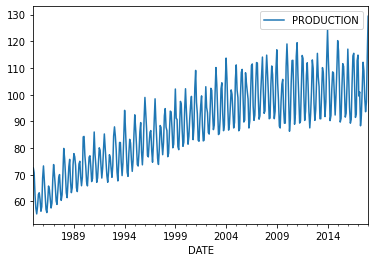

In [5]:
df.plot()

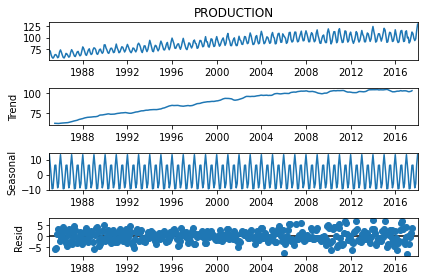

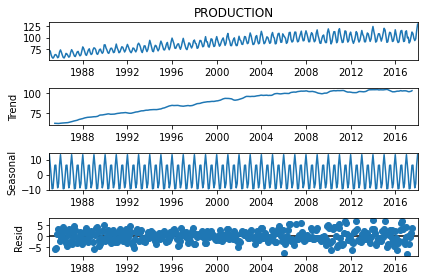

In [6]:
results = seasonal_decompose(df['PRODUCTION'], freq=12)
results.plot()

In [7]:
len(df)

397

In [8]:
train = df.iloc[:372]
test = df.iloc[372:396]

scaler = MinMaxScaler()

In [9]:
df.head(), df.tail()

(            PRODUCTION
 DATE                  
 1985-01-01     72.5052
 1985-02-01     70.6720
 1985-03-01     62.4502
 1985-04-01     57.4714
 1985-05-01     55.3151,
             PRODUCTION
 DATE                  
 2017-09-01     98.6154
 2017-10-01     93.6137
 2017-11-01     97.3359
 2017-12-01    114.7212
 2018-01-01    129.4048)

In [10]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[:10]

array([[0.24934943],
       [0.22275812],
       [0.10349754],
       [0.03127801],
       [0.        ],
       [0.04025686],
       [0.10596346],
       [0.11507721],
       [0.07643625],
       [0.01450976]])

# Recursive Strategy

In [11]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=1)

generator[0]

(array([[[0.24934943],
         [0.22275812],
         [0.10349754],
         [0.03127801],
         [0.        ],
         [0.04025686],
         [0.10596346],
         [0.11507721],
         [0.07643625],
         [0.01450976],
         [0.03895283],
         [0.19436378]]]),
 array([[0.26096101]]))

In [12]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit(generator, epochs=50, verbose=0)

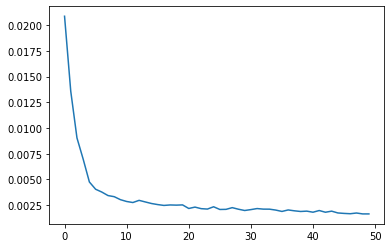

In [14]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [15]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1,n_input, n_features))

model.predict(last_train_batch)

array([[0.90562505]], dtype=float32)

In [16]:
scaled_test[0], scaled_test[1]

(array([0.89597881]), array([0.74490643]))

In [17]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.90562505], dtype=float32),
 array([0.902206], dtype=float32),
 array([0.73985946], dtype=float32),
 array([0.55739105], dtype=float32),
 array([0.532106], dtype=float32),
 array([0.7010422], dtype=float32),
 array([0.85903305], dtype=float32),
 array([0.83541155], dtype=float32),
 array([0.70123637], dtype=float32),
 array([0.5661469], dtype=float32),
 array([0.5586697], dtype=float32),
 array([0.720302], dtype=float32),
 array([0.9023418], dtype=float32),
 array([0.90441674], dtype=float32),
 array([0.7557188], dtype=float32),
 array([0.5936496], dtype=float32),
 array([0.5524254], dtype=float32),
 array([0.71146494], dtype=float32),
 array([0.88185585], dtype=float32),
 array([0.8658543], dtype=float32),
 array([0.72635204], dtype=float32),
 array([0.59395397], dtype=float32),
 array([0.57299685], dtype=float32),
 array([0.7333184], dtype=float32)]

In [18]:
test.head()

,PRODUCTION
DATE,
2016-01-01,117.0837
2016-02-01,106.6688
2016-03-01,95.3548
2016-04-01,89.3254
2016-05-01,90.7369


In [19]:
true_predictions = scaler.inverse_transform(test_predictions)

test['recursive_predict'] = true_predictions

<AxesSubplot:xlabel='DATE'>

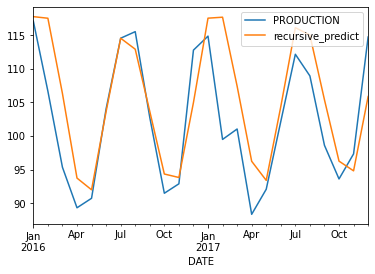

In [20]:
test.plot()

In [21]:
rmse = sqrt(mean_squared_error(test['PRODUCTION'], test['recursive_predict']))
print(rmse)

6.370860264525652


In [22]:
test

,PRODUCTION,recursive_predict
DATE,,
2016-01-01,117.0837,117.748709
2016-02-01,106.6688,117.513001
2016-03-01,95.3548,106.320863
2016-04-01,89.3254,93.741527
2016-05-01,90.7369,91.998380
2016-06-01,104.0375,103.644807
2016-07-01,114.5397,114.536667
2016-08-01,115.5159,112.908205
2016-09-01,102.7637,103.658195


# Direct Startegy

In [23]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [24]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    
    #print("MODEL : ", m_no)
    #print(X[0], y[0])
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [25]:
n_input = 12
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    test_predictions.append(model_predict(i+1,scaled_train,n_input, n_features))
    
test_predictions

[array([0.9385326], dtype=float32),
 array([0.88135755], dtype=float32),
 array([0.7649584], dtype=float32),
 array([0.51063836], dtype=float32),
 array([0.53040516], dtype=float32),
 array([0.6774172], dtype=float32),
 array([0.82774603], dtype=float32),
 array([0.8342476], dtype=float32),
 array([0.7073148], dtype=float32),
 array([0.54304314], dtype=float32),
 array([0.5080101], dtype=float32),
 array([0.7136346], dtype=float32),
 array([0.88926977], dtype=float32),
 array([0.9423803], dtype=float32),
 array([0.72701705], dtype=float32),
 array([0.5596711], dtype=float32),
 array([0.5164839], dtype=float32),
 array([0.7017783], dtype=float32),
 array([0.94940835], dtype=float32),
 array([0.8594607], dtype=float32),
 array([0.7202757], dtype=float32),
 array([0.5354187], dtype=float32),
 array([0.4989238], dtype=float32),
 array([0.7141853], dtype=float32)]

In [26]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_predict'] = true_predictions

<AxesSubplot:xlabel='DATE'>

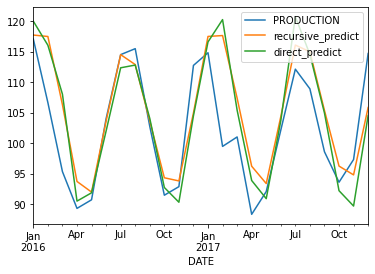

In [27]:
test.plot()

In [28]:
rmse = sqrt(mean_squared_error(test['PRODUCTION'], test['direct_predict']))
print(rmse)

6.934560896479126


In [29]:
test

,PRODUCTION,recursive_predict,direct_predict
DATE,,,
2016-01-01,117.0837,117.748709,120.017349
2016-02-01,106.6688,117.513001,116.075713
2016-03-01,95.3548,106.320863,108.051178
2016-04-01,89.3254,93.741527,90.518406
2016-05-01,90.7369,91.998380,91.881126
2016-06-01,104.0375,103.644807,102.016108
2016-07-01,114.5397,114.536667,112.379746
2016-08-01,115.5159,112.908205,112.827962
2016-09-01,102.7637,103.658195,104.077240


# Direct Recursive Startegy

In [30]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input+(month-1)])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [31]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input+(m_no - 1), n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    #print(y.dtype)
    
    #print("Model No.  - ", m_no)
    #print(X[0], y[0])
    #print("SHAPE XY : ", X.shape, y.shape)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    tP = np.array(test_predictions)
    
    tX = np.concatenate((tX, tP), axis=None)
    
    #print("TYPE : ", type(tX), type(tP))
    
    #print("TX : ", tX)
        
    #print("SHAPE : " , tX.shape)
    
    tX = tX.reshape((1, tX.shape[0], n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [32]:
n_input = 12
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    pred = model_predict(i+1,scaled_train,n_input, n_features)
    test_predictions.append(pred)
    
test_predictions

[array([0.89596945], dtype=float32),
 array([0.89648867], dtype=float32),
 array([0.699828], dtype=float32),
 array([0.5344653], dtype=float32),
 array([0.5839077], dtype=float32),
 array([0.592222], dtype=float32),
 array([0.7610257], dtype=float32),
 array([0.8928505], dtype=float32),
 array([0.7298396], dtype=float32),
 array([0.5396926], dtype=float32),
 array([0.65312], dtype=float32),
 array([0.73917925], dtype=float32),
 array([0.94275653], dtype=float32),
 array([0.96078104], dtype=float32),
 array([0.7155212], dtype=float32),
 array([0.49784306], dtype=float32),
 array([0.5149308], dtype=float32),
 array([0.7061537], dtype=float32),
 array([0.9685749], dtype=float32),
 array([0.7397499], dtype=float32),
 array([0.7412367], dtype=float32),
 array([0.4823928], dtype=float32),
 array([0.59079385], dtype=float32),
 array([0.8624689], dtype=float32)]

In [33]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_recursive_predict'] = true_predictions

<AxesSubplot:xlabel='DATE'>

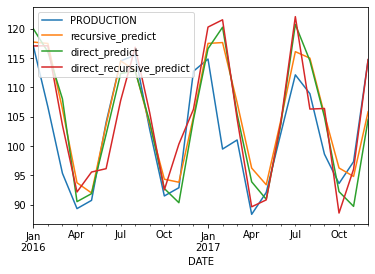

In [34]:
test.plot()

In [35]:
rmse = sqrt(mean_squared_error(test['PRODUCTION'], test['direct_recursive_predict']))
print(rmse)

6.935406072670913


In [36]:
test

,PRODUCTION,recursive_predict,direct_predict,direct_recursive_predict
DATE,,,,
2016-01-01,117.0837,117.748709,120.017349,117.083055
2016-02-01,106.6688,117.513001,116.075713,117.118849
2016-03-01,95.3548,106.320863,108.051178,103.561104
2016-04-01,89.3254,93.741527,90.518406,92.161032
2016-05-01,90.7369,91.998380,91.881126,95.569582
2016-06-01,104.0375,103.644807,102.016108,96.142765
2016-07-01,114.5397,114.536667,112.379746,107.780061
2016-08-01,115.5159,112.908205,112.827962,116.868036
2016-09-01,102.7637,103.658195,104.077240,105.630098


# MIMO

In [37]:
def generate_data(data, n_input, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input+n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input: i+n_input+n_output])
    return np.array(X), np.array(y)

In [38]:
n_input = 12
n_features = 1
n_output = len(scaled_test)

X, y = generate_data(scaled_train, n_input, n_output)

In [39]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [40]:
model.fit(X, y, epochs=50, verbose=0)

In [41]:
model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_49 (Dense)             (None, 24)                4824      
Total params: 166,424
Trainable params: 166,424
Non-trainable params: 0
_________________________________________________________________


In [42]:
tX = scaled_train[-n_input:]
tX = tX.reshape((1, tX.shape[0], n_features))

res = model.predict(tX)

res = res.reshape((res.shape[1],1))

In [43]:
res.shape

(24, 1)

In [44]:
true_predictions = scaler.inverse_transform(res)

test['MIMO_predict'] = true_predictions

In [45]:
test

,PRODUCTION,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict
DATE,,,,,
2016-01-01,117.0837,117.748709,120.017349,117.083055,113.875908
2016-02-01,106.6688,117.513001,116.075713,117.118849,113.877274
2016-03-01,95.3548,106.320863,108.051178,103.561104,102.623436
2016-04-01,89.3254,93.741527,90.518406,92.161032,91.368294
2016-05-01,90.7369,91.998380,91.881126,95.569582,92.884476
2016-06-01,104.0375,103.644807,102.016108,96.142765,106.020218
2016-07-01,114.5397,114.536667,112.379746,107.780061,115.447098
2016-08-01,115.5159,112.908205,112.827962,116.868036,114.888359
2016-09-01,102.7637,103.658195,104.077240,105.630098,101.384491


<AxesSubplot:xlabel='DATE'>

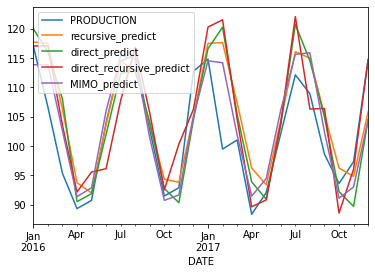

In [46]:
test.plot()

In [47]:
rmse = sqrt(mean_squared_error(test['PRODUCTION'], test['MIMO_predict']))
print(rmse)

5.189908207734469


# Direct MIMO

In [54]:
def generate_data(data, n_input, q_no, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input + ((q_no-1)*n_output) + n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input+((q_no-1)*n_output): i+n_input+((q_no-1)*n_output) + n_output])
    return np.array(X), np.array(y)

In [55]:
def model_predict(train_data, n_input, n_features, q_no, n_output):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, q_no, n_output)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res

In [56]:
n_input = 12
n_features = 1
test_predictions = []

q = int(len(scaled_test)/4)

n_output = q

for i in range(q):
    pred = model_predict(scaled_train,n_input, n_features, i+1, n_output)
    test_predictions.append(pred)

test_predictions

[array([[0.9206293 , 0.89961743, 0.69005394, 0.44535753, 0.44948608,
         0.6842643 ]], dtype=float32),
 array([[0.8516358 , 0.83230275, 0.6581642 , 0.5046023 , 0.53643125,
         0.71430624]], dtype=float32),
 array([[0.8771535 , 0.86723673, 0.6846267 , 0.5672026 , 0.5798596 ,
         0.71847534]], dtype=float32),
 array([[0.9185139, 0.8697526, 0.6741927, 0.5402193, 0.5801066, 0.7558885]],
       dtype=float32),
 array([[0.878637  , 0.84733474, 0.6628586 , 0.4986524 , 0.53294814,
         0.71554065]], dtype=float32),
 array([[0.8680158 , 0.8468122 , 0.709087  , 0.57901394, 0.5951237 ,
         0.72705954]], dtype=float32)]

In [57]:
res = []

for i in test_predictions:
    for j in i:
        for k in j:
            res.append(k)

In [58]:
res = np.array(res[:len(scaled_test)])
res = res.reshape((res.shape[0],1))
res.shape

(24, 1)

In [59]:
true_predictions = scaler.inverse_transform(res)

test['Direct_MIMO_predict'] = true_predictions

In [60]:
test

,PRODUCTION,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict,Direct_MIMO_predict
DATE,,,,,,
2016-01-01,117.0837,117.748709,120.017349,117.083055,113.875908,118.783096
2016-02-01,106.6688,117.513001,116.075713,117.118849,113.877274,117.334549
2016-03-01,95.3548,106.320863,108.051178,103.561104,102.623436,102.887283
2016-04-01,89.3254,93.741527,90.518406,92.161032,91.368294,86.017960
2016-05-01,90.7369,91.998380,91.881126,95.569582,92.884476,86.302574
2016-06-01,104.0375,103.644807,102.016108,96.142765,106.020218,102.488144
2016-07-01,114.5397,114.536667,112.379746,107.780061,115.447098,114.026703
2016-08-01,115.5159,112.908205,112.827962,116.868036,114.888359,112.693878
2016-09-01,102.7637,103.658195,104.077240,105.630098,101.384491,100.688805


<AxesSubplot:xlabel='DATE'>

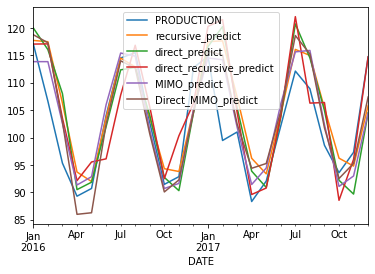

In [61]:
test.plot()

In [62]:
rmse = sqrt(mean_squared_error(test['PRODUCTION'], test['Direct_MIMO_predict']))
print(rmse)

5.554888186061383


In [63]:
rec_err = abs(test['PRODUCTION'] - test['recursive_predict'])
dir_err = abs(test['PRODUCTION'] - test['direct_predict'])
dir_rec_err = abs(test['PRODUCTION'] - test['direct_recursive_predict'])
mimo_err = abs(test['PRODUCTION'] - test['MIMO_predict'])
dir_mimo_err = abs(test['PRODUCTION'] - test['Direct_MIMO_predict'])

In [64]:
errors = pd.DataFrame({
    'Recursive':rec_err,
    'Direct':dir_err,
    'Direct Recursive':dir_rec_err,
    'MIMO':mimo_err,
    'Direct MIMO':dir_mimo_err
})

In [65]:
errors

,Recursive,Direct,Direct Recursive,MIMO,Direct MIMO
DATE,,,,,
2016-01-01,0.665009,2.933649,0.000645,3.207792,1.699396
2016-02-01,10.844201,9.406913,10.450049,7.208474,10.665749
2016-03-01,10.966063,12.696378,8.206304,7.268636,7.532483
2016-04-01,4.416127,1.193006,2.835632,2.042894,3.307440
2016-05-01,1.261480,1.144226,4.832682,2.147576,4.434326
2016-06-01,0.392693,2.021392,7.894735,1.982718,1.549356
2016-07-01,0.003033,2.159954,6.759639,0.907398,0.512997
2016-08-01,2.607695,2.687938,1.352136,0.627541,2.822022
2016-09-01,0.894495,1.313540,2.866398,1.379209,2.074895


<AxesSubplot:xlabel='DATE'>

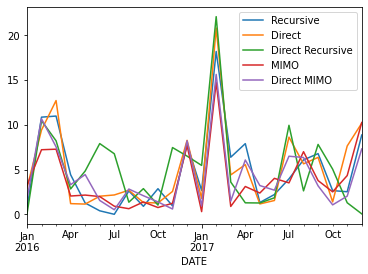

In [66]:
errors.plot()

In [67]:
len(scaled_test)

24